# Data Schema
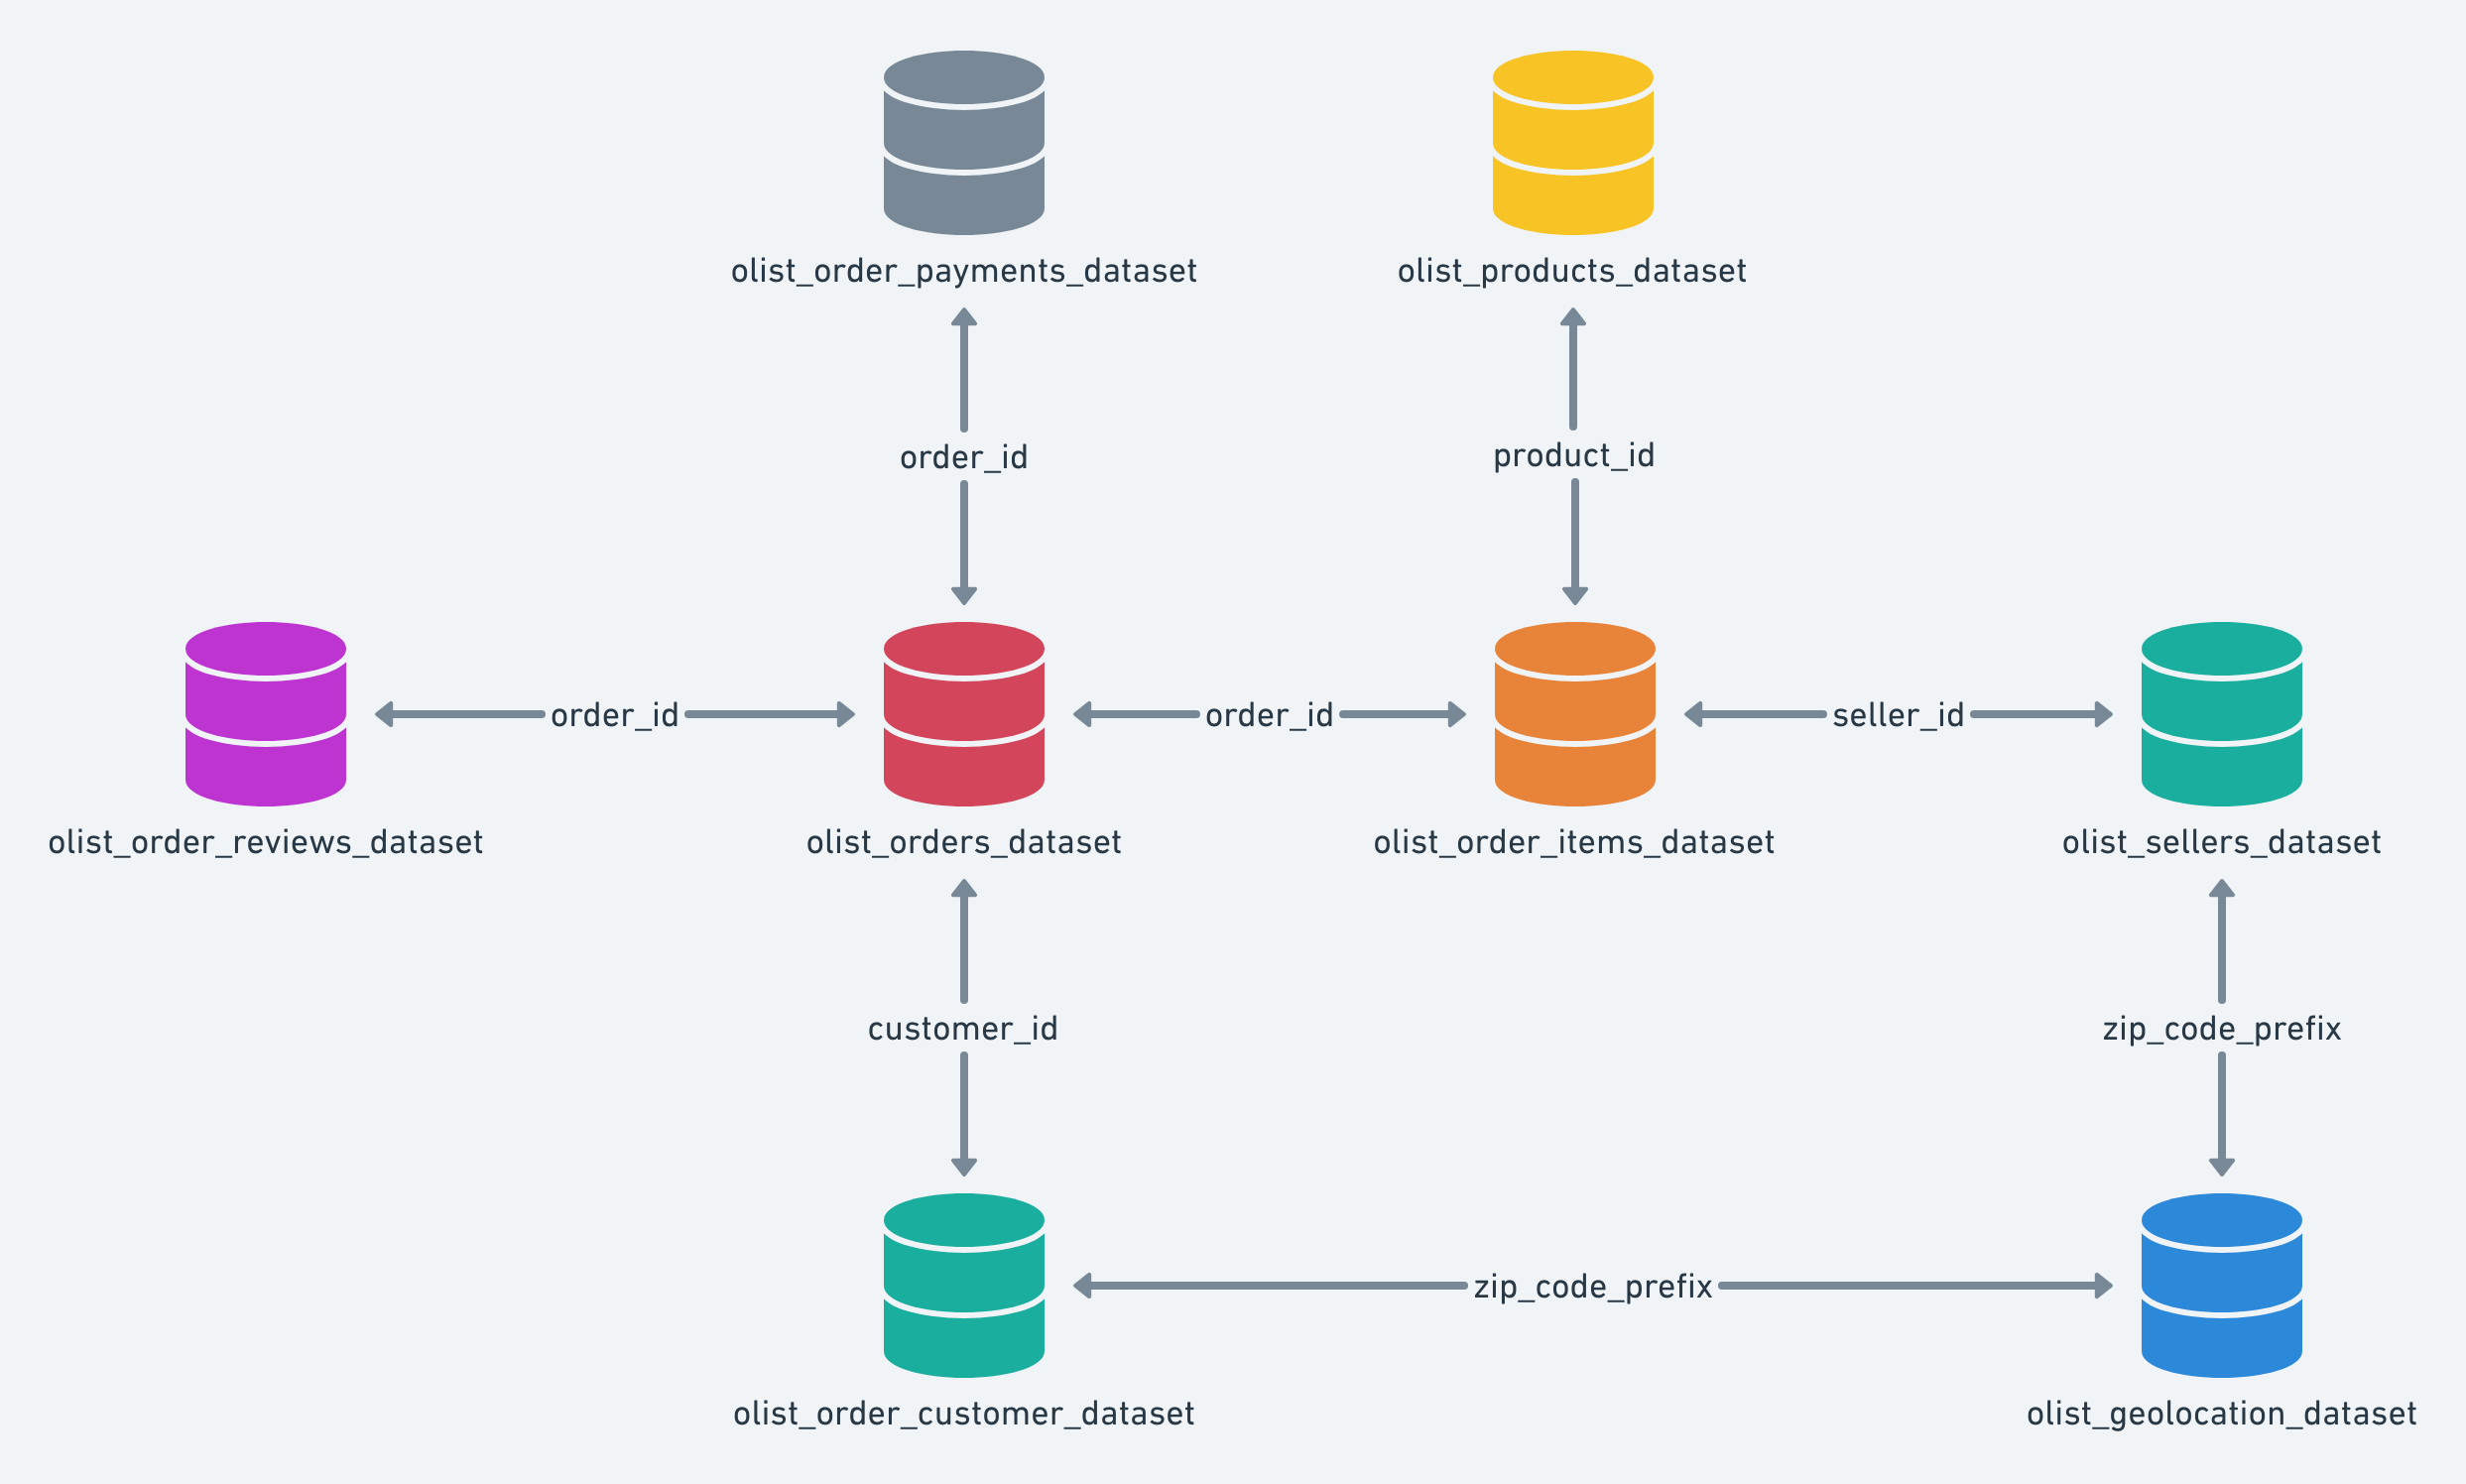

In [1]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dir = "/content/drive/My Drive/Colab Notebooks/Customer Segmentation/datasets/"
customer_dir = dir + "olist_customers_dataset.csv"
order_items_dir = dir + "olist_order_items_dataset.csv"
order_payments_dir = dir + "olist_order_payments_dataset.csv"
orders_dir = dir + "olist_orders_dataset.csv"
products_dir = dir + "olist_products_dataset.csv"
product_category_name_translation_dir = dir + "product_category_name_translation.csv"

In [4]:
customer_df = pd.read_csv(customer_dir)
order_items_df = pd.read_csv(order_items_dir)
order_payments_df = pd.read_csv(order_payments_dir)
orders_df = pd.read_csv(orders_dir)
products_df = pd.read_csv(products_dir)
product_category_name_translation_df = pd.read_csv(product_category_name_translation_dir)

# Summary of the datasets

In [5]:
input_df = [customer_df, order_items_df, order_payments_df, orders_df, products_df, product_category_name_translation_df]
titles = ["customers", "items", "payments", "orders", "products", "category_translation"]

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col in data.columns.tolist() ]) for data in input_df]
data_summary['total_rows']= [data.shape[0] for data in input_df]
data_summary['total_cols']= [data.shape[1] for data in input_df]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in input_df]
data_summary['total_null']= [data.isnull().sum().sum() for data in input_df]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in input_df]
data_summary.style.background_gradient(cmap='YlGnBu')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
2,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
3,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441,8,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
4,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
5,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


Drop the NA rows

In [6]:
for df in input_df:
    df.dropna(inplace=True)

Check the Summary again

In [7]:

input_df = [customer_df, order_items_df, order_payments_df, orders_df, products_df, product_category_name_translation_df]
titles = ["customers", "items", "payments", "orders", "products", "category_translation"]

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles

data_summary['columns'] = [', '.join([col for col in data.columns.tolist() ]) for data in input_df]
data_summary['total_rows']= [data.shape[0] for data in input_df]
data_summary['total_cols']= [data.shape[1] for data in input_df]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in input_df]
data_summary['total_null']= [data.isnull().sum().sum() for data in input_df]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in input_df]
data_summary.style.background_gradient(cmap='YlGnBu')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
2,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
3,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",96461,8,0,0,
4,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32340,9,0,0,
5,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


# Convert to SQL for Analysis


In [8]:
# import sqlalchemy and create a sqlite engine
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

# export the dataframe as a table 'playstore' to the sqlite engine
customer_df.to_sql("olist_customers", con =engine)
order_items_df.to_sql("olist_order_items", con =engine)
products_df.to_sql("olist_products_dataset", con =engine)
product_category_name_translation_df.to_sql("product_category_name_translation", con =engine)
orders_df.to_sql("olist_orders", con =engine)
order_payments_df.to_sql("olist_order_payments", con =engine)

In [9]:
query = "SELECT * FROM sqlite_master"
db = pd.read_sql_query(sql = query, con = engine)
db[db['type'] == 'table']

,type,name,tbl_name,rootpage,sql
0,table,olist_customers,olist_customers,2,"CREATE TABLE olist_customers (\n\t""index"" BIGI..."
2,table,olist_order_items,olist_order_items,2644,"CREATE TABLE olist_order_items (\n\t""index"" BI..."
4,table,olist_products_dataset,olist_products_dataset,7179,"CREATE TABLE olist_products_dataset (\n\t""inde..."
6,table,product_category_name_translation,product_category_name_translation,7863,CREATE TABLE product_category_name_translation...
8,table,olist_orders,olist_orders,7865,"CREATE TABLE olist_orders (\n\t""index"" BIGINT,..."
10,table,olist_order_payments,olist_order_payments,12779,"CREATE TABLE olist_order_payments (\n\t""index""..."


Query 1: Overview of the Order Status

In [10]:
stat = """
  select order_status, count(order_status) as Count
  from olist_orders
  group by order_status
"""

status=pd.read_sql_query(stat, engine)
status

,order_status,Count
0,canceled,6
1,delivered,96455


Query 2: Total Sales per month

<AxesSubplot:xlabel='Month', ylabel='Sales'>

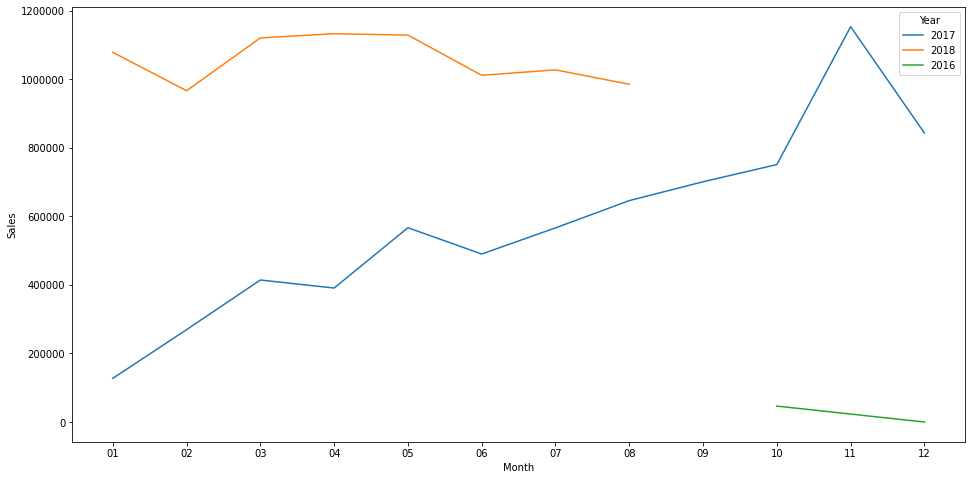

In [ ]:
sales = """
    select strftime('%m', o.order_purchase_timestamp) as Month, strftime('%Y', o.order_purchase_timestamp) as Year, sum(p.payment_value) as Sales
    from olist_orders as o
    left join olist_order_payments as p
      on o.order_id = p.order_id
    where o.order_status='delivered' and p.payment_value > 0
    group by Month, Year
    order by MOnth, Year
  """

sales=pd.read_sql_query(sales, engine)
plt.figure(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')
sns.lineplot(data=sales, x='Month', y='Sales', hue='Year')

Query 3: Top 10 Customers with Highest Sales Amount

<AxesSubplot:xlabel='Total_Payment', ylabel='Customer_ID'>

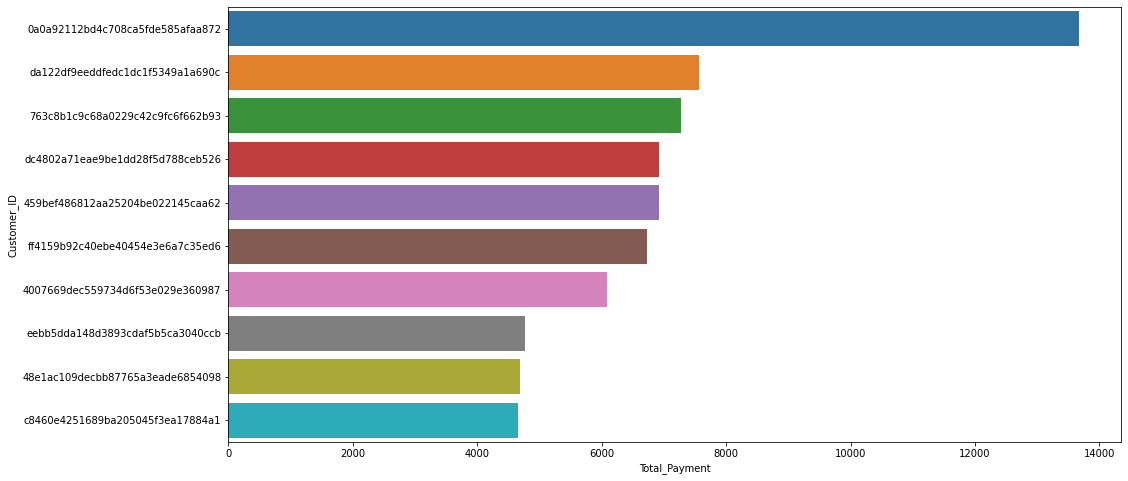

In [ ]:
cus = """
  select c.customer_unique_id as Customer_ID, sum(p.payment_value) as Total_Payment
  from olist_orders as o
  left join olist_order_payments as p
    on o.order_id = p.order_id
  left join olist_customers as c
    on o.customer_id = c.customer_id
  where o.order_status='delivered' and p.payment_value > 0
  group by c.customer_unique_id
  order by Total_Payment DESC
  limit 10
"""

cus = pd.read_sql_query(cus, engine)
plt.figure(figsize=(16,8))
sns.barplot(data=cus, x="Total_Payment", y="Customer_ID")

Query 4: Pareto Analysis of the Products

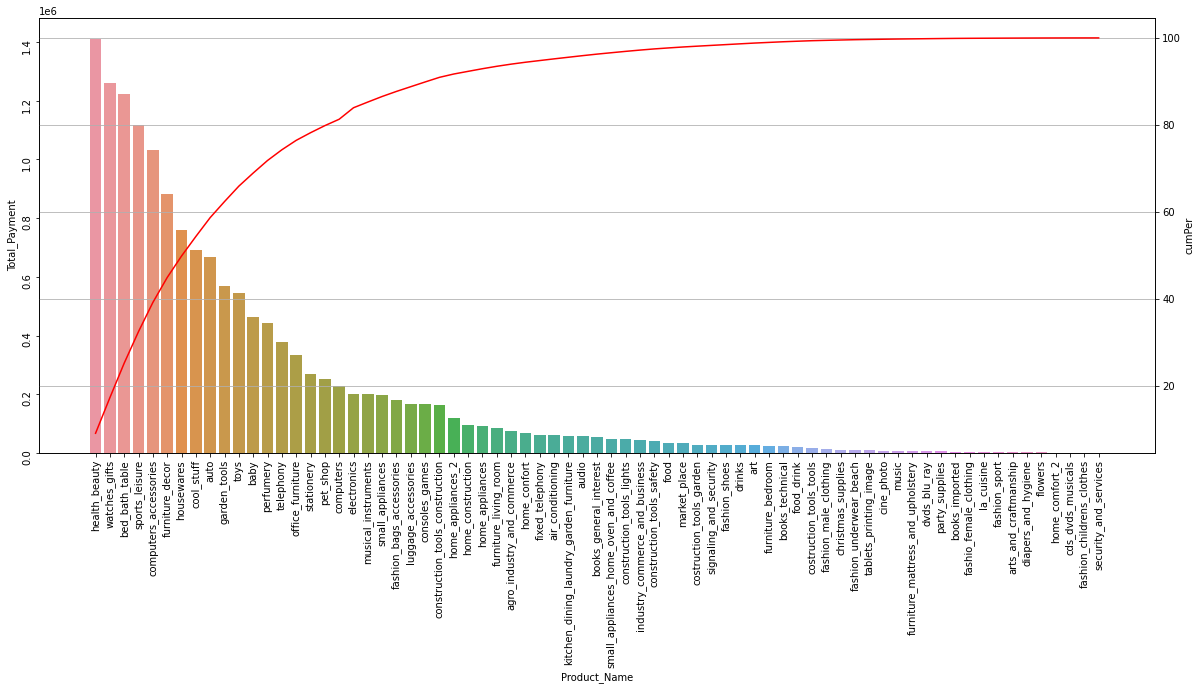

In [ ]:
par = """
  with overall_payments as
  (  
    select sum(p.payment_value) as t
    from olist_orders as o
    left join olist_order_payments as p
      on o.order_id = p.order_id
    where o.order_status='delivered' and p.payment_value > 0
  )
  select
    Product_Name, Total_Payment,
    sum(Total_Payment) over (order by Total_Payment desc) as cumsum,
    sum(Total_Payment) over (order by Total_Payment desc) / overall_payments.t * 100 as cumPer
  from(
    select n.product_category_name_english as Product_Name, sum(p.payment_value) as Total_Payment
    from olist_orders as o
    left join olist_order_payments as p
      on o.order_id = p.order_id
    left join (select order_id, product_id from olist_order_items group by order_id) as i
      on o.order_id = i.order_id
    left join olist_products_dataset as pr
      on i.product_id = pr.product_id
    left join product_category_name_translation as n
      on n.product_category_name = pr.product_category_name
    where o.order_status='delivered' and p.payment_value > 0
    group by Product_Name
    order by Total_Payment DESC
  ), overall_payments

"""

par = pd.read_sql_query(par, engine)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='Product_Name', y='Total_Payment', data=par, ax=ax)
ax2 = ax.twinx()
sns.lineplot(x='Product_Name', y='cumPer', data=par, ax=ax2, color='r')
ax.tick_params(labelrotation=90)
plt.grid()
plt.show()

In [ ]:
print("Total of 17 products contribute to 80% of the sales:")
print(par.Product_Name[par.cumPer <= 80])

Total of 17 products contribute to 80% of the sales:
0             health_beauty
1             watches_gifts
2            bed_bath_table
3            sports_leisure
4     computers_accessories
5           furniture_decor
6                housewares
7                cool_stuff
8                      auto
9              garden_tools
10                     toys
11                     baby
12                perfumery
13                telephony
14         office_furniture
15               stationery
16                 pet_shop
Name: Product_Name, dtype: object


# Customer Segmentation


Generate RFM columns

R: Recency (How many days ago was this customer's last purchase?)

F: Frequency (How many purchases has this customer made at your company since signing up?)

M: Monetarity (How much money has this customer spent in your company?)

In [ ]:
rfm = """
  with lastDate as
  (
    select max(date(order_purchase_timestamp)) as d
    from olist_orders as o
  )
  select rec.cid,rec.R, fre.F, mon.M
  from
  (
    select c. customer_unique_id as cid, (JULIANDAY(lastDate.d) - JULIANDAY(max(date(o.order_purchase_timestamp)))) as R
    from 
    (
    olist_orders as o
    left join olist_customers as c
      on o.customer_id = c.customer_id
    ),lastDate
    where o.order_status='delivered'
    group by c.customer_unique_id
  ) as rec
  left join
  (
    select c. customer_unique_id as cid, count(*) as F
    from olist_orders as o
    left join olist_customers as c
      on o.customer_id = c.customer_id
    where o.order_status='delivered'
    group by c.customer_unique_id
  ) as fre
  on rec.cid = fre.cid
  left join 
  (
    select c. customer_unique_id as cid, sum(p.payment_value) as M
    from olist_orders as o
    left join olist_customers as c
      on o.customer_id = c.customer_id
    left join olist_order_payments as p
      on o.order_id = p.order_id
    where o.order_status='delivered' and p.payment_value > 0
    group by c.customer_unique_id
  ) as mon
  on rec.cid = mon.cid
"""

rfm = pd.read_sql_query(rfm, engine)
rfm.head()

,cid,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,27.19
2,0000f46a3911fa3c0805444483337064,537.0,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321.0,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288.0,1,196.89


Check missing value

In [ ]:
rfm.isna().sum()

cid    0
R      0
F      0
M      1
dtype: int64

drop missing value

In [ ]:
# removing null data 
rfm = rfm[rfm['M'].notnull()]
rfm.isna().sum()

cid    0
R      0
F      0
M      0
dtype: int64

Check the distribution of the R, F, M

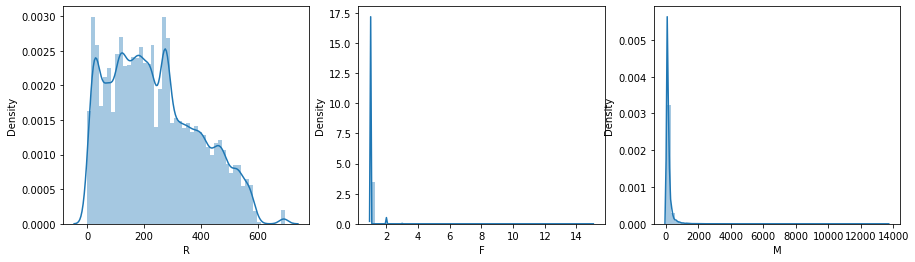

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes = axes.flatten()

for col, ax in zip(['R', 'F', 'M'], axes):
    sns.distplot(rfm[col], ax = ax)
    
plt.show()

AS F and M are largely skewed, apply log transform 

In [ ]:
rfm_log= rfm[rfm.columns[1:]].copy()
for i in rfm_log.columns[1:]:
    rfm_log[i] = np.log10(rfm_log[i])
rfm_log.head()

,R,F,M
0,111.0,0.0,2.151982
1,114.0,0.0,1.434409
2,537.0,0.0,1.935608
3,321.0,0.0,1.639686
4,288.0,0.0,2.294224


Recheck the distribution

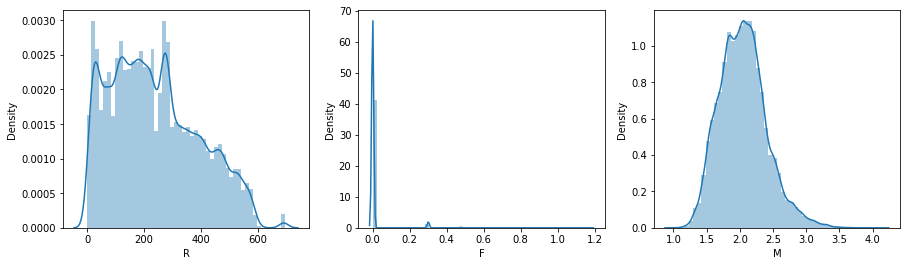

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes = axes.flatten()

for col, ax in zip(['R', 'F', 'M'], axes):
    sns.distplot(rfm_log[col], ax = ax)
    
plt.show()

Apply StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()

RFM_log_scaled= scaler.fit_transform(rfm_log)
RFM_log_scaled_df= pd.DataFrame(RFM_log_scaled)
RFM_log_scaled_df.columns = ['R', 'F', 'M']
RFM_log_scaled_df.head()

,R,F,M
0,-0.828823,-0.17218,0.291397
1,-0.809157,-0.17218,-1.732458
2,1.963729,-0.17218,-0.318869
3,0.547787,-0.17218,-1.153493
4,0.331462,-0.17218,0.692577


Determine the k value for Kmean clustering using Elbow Method and Silhouette Score


In [ ]:
from sklearn.cluster import KMeans

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=32)
    kmeanModel.fit(RFM_log_scaled_df)
    distortions.append(kmeanModel.inertia_)

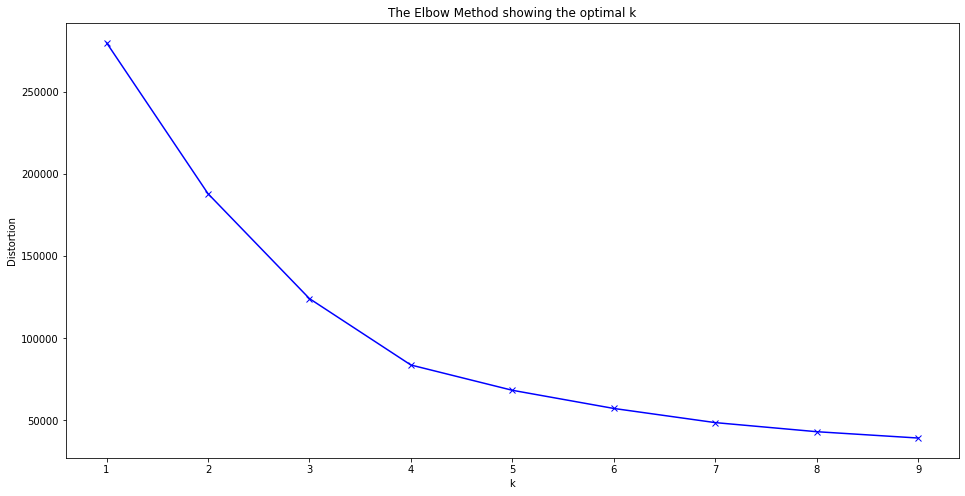

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe that the “elbow” is the number 4 which is optimal. Let's examine with silhouette score

Silhouette Score is a metric used to calculate the goodness of a clustering technique, where 1 means that clusters are well apart from each other and they’re clearly distinguished, 0 means that clusters are indifferent and -1 means that clusters are assigned in the wrong way 

In [ ]:
from sklearn.metrics import silhouette_score
print('Silhouette score for:')
for k in range(3, 10):
    labels=KMeans(n_clusters=k, random_state=32).fit(RFM_log_scaled_df).labels_
    score=silhouette_score(RFM_log_scaled_df, labels, metric='euclidean', random_state=23)
    print(f'{k} clusters: {score}')

Silhouette score for:
3 clusters: 0.35816309100232574
4 clusters: 0.36938735442711484
5 clusters: 0.3532880729877177
6 clusters: 0.3445627149518213
7 clusters: 0.3580648941398204
8 clusters: 0.34840492830090614
9 clusters: 0.3477400739740519


The highest score is obtained with 4 clusters

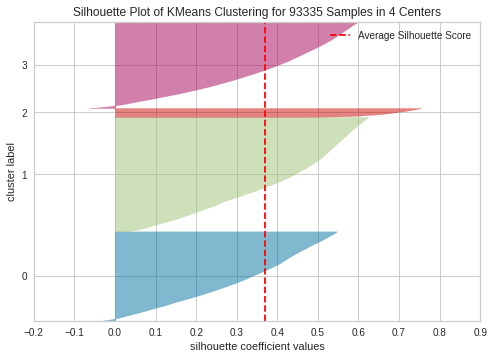

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93335 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=4, random_state=32)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(RFM_log_scaled_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Append cluster to RFM data

In [ ]:
model = KMeans(n_clusters=4, random_state=32)
kmeans = model.fit(RFM_log_scaled_df)
rfm['cluster'] = kmeans.labels_

Let's see the data distribution per cluster.



In [ ]:
rfm.groupby('cluster').mean()

,R,F,M
cluster,,,
0,174.445101,1.000000,318.396550
1,146.740815,1.000000,69.250624
2,219.779286,2.113929,308.592029
3,425.074538,1.000000,118.624968


cluster 0: second lowest recency, highest spending (Big spenders)

cluster 1: lowest recency, lowest spending (Relatively New Comers/Low spenders)

cluster 2: frequncy is highest, spending second highest (Loyal customers)

cluster 3: highest recency and second lowest spending (Lost/Low spenders)

Update cluster code to label

In [ ]:
dow = {
    0:"Big spenders",
    1:"Relatively New Comers/Low spenders",
    2:"Loyal customers",
    3:"Lost/Low spenders", 
}
rfm["segment"] = rfm['cluster'].map(dow)

In [ ]:
rfm.head()

,cid,R,F,M,cluster,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,141.90,0,Big spenders
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,27.19,1,Relatively New Comers/Low spenders
2,0000f46a3911fa3c0805444483337064,537.0,1,86.22,3,Lost/Low spenders
3,0000f6ccb0745a6a4b88665a16c9f078,321.0,1,43.62,3,Lost/Low spenders
4,0004aac84e0df4da2b147fca70cf8255,288.0,1,196.89,0,Big spenders


Export Segment data to csv

In [ ]:
rfm.to_csv(dir + 'customer_segment.csv')